In [8]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from Code.logistic_regression import log_loss_ridge, import_breast_cancer, accuracy_func, logistic_loss_func, logistic_grad, ridge_term
from Code.utilities import train_test_split, plot_test_results
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam

from matplotlib import pyplot as plt

import jax.numpy as jnp
import numpy as np
from jax import nn, grad

In [9]:
X, y = import_breast_cancer()



c:\Users\eirik\Desktop\UIO\FYSSTK\Project2_FYS_STK4155\Code\logistic_regression.py:47: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  X = jnp.array(data.to_numpy()[:, 1:-1], dtype=jnp.float64)


(683,)
(683, 9)
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


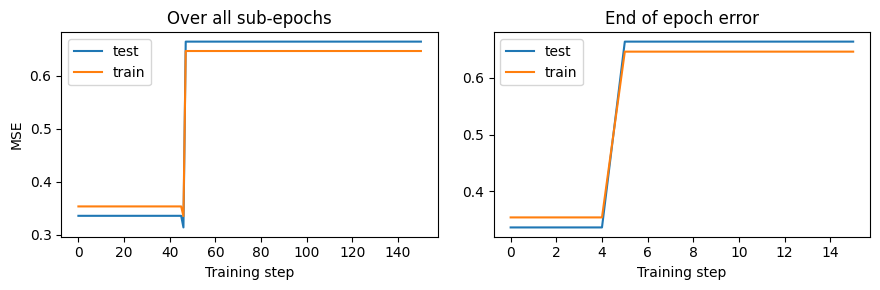

Log run


In [10]:
def single_run(X, y, lr, lam, hidden_layer_num, node_per_hidden, hidden_activation, test_index=None):
    layer_list = [X.shape[1]] + [node_per_hidden]*hidden_layer_num + [1]
    beta0 = _beta_init(layer_list)
    print(beta0.keys())

    batch_size = 50
    epochs = 15

    model = get_neural_network_model(hidden_layer_num ,activation=hidden_activation, output_activation=nn.sigmoid)

    #loss_func = logistic_loss_func(model=model)


    loss_func = log_loss_ridge(model=model, lam=lam)

    loss_grad = grad(loss_func)

    test_func = accuracy_func(model)

    X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=test_index)

    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, batch_size=batch_size, test_loss_func=test_func, lr=lr)

    m = int(len(y_train) / batch_size)
    result.update({"test_index":test_index, "m":m})

    plot_test_results(result["test_loss_list"], result["train_loss_list"], result["m"])
    # result2 = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, batch_size=batch_size, test_loss_func=test_func, lr=lr)
    # plot_test_results(result2["test_loss_list"], result2["train_loss_list"], result["m"])


    return result




print(y.shape)
print(X.shape)
result = single_run(X, y, 0.01, 0.001, hidden_layer_num=2, node_per_hidden=5, hidden_activation=nn.sigmoid)
print("Log run")
#result = single_run(X, y, 0.01, 0.001, 0, 5, hidden_activation=nn.relu)



1e-08
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


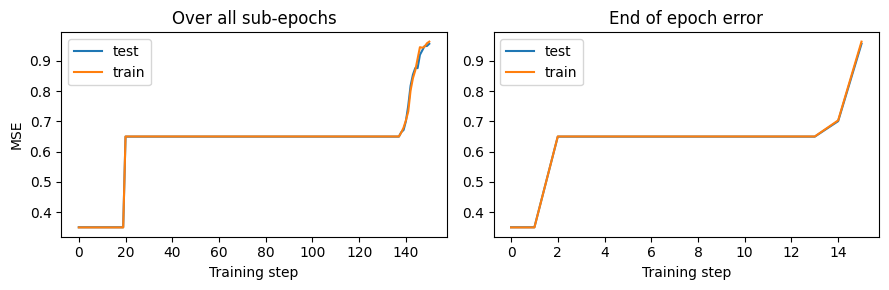

2.2122162910704503e-08
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


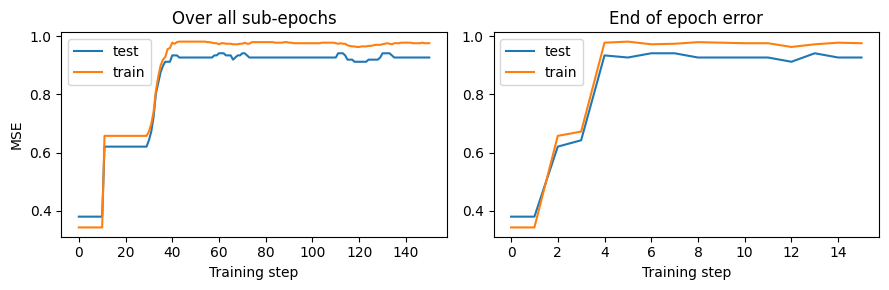

4.893900918477499e-08
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


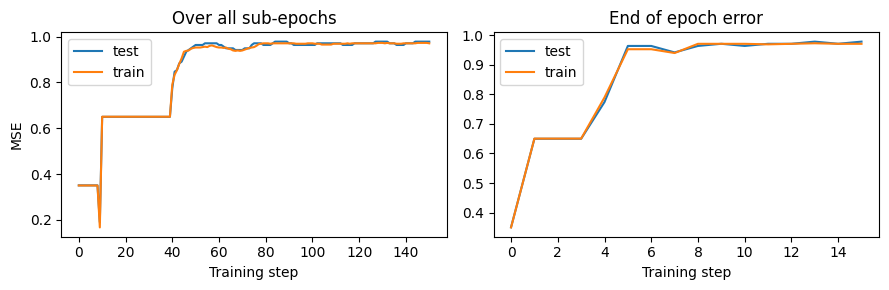

1.0826367338740541e-07
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


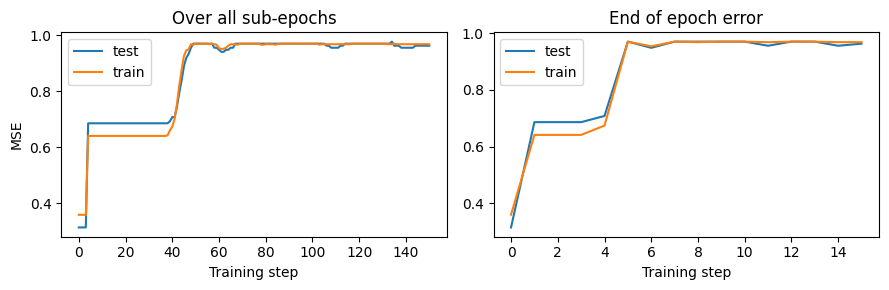

2.395026619987486e-07
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


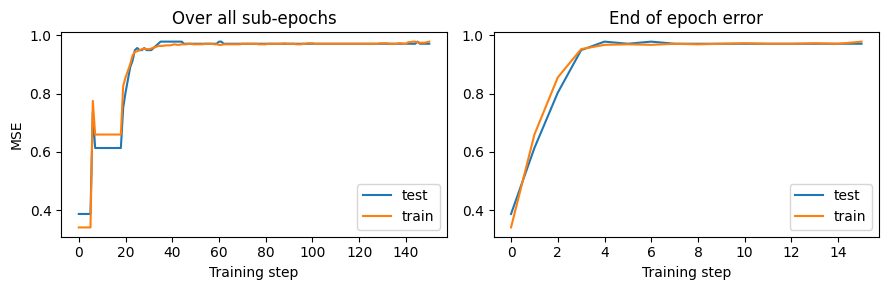

5.298316906283712e-07
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


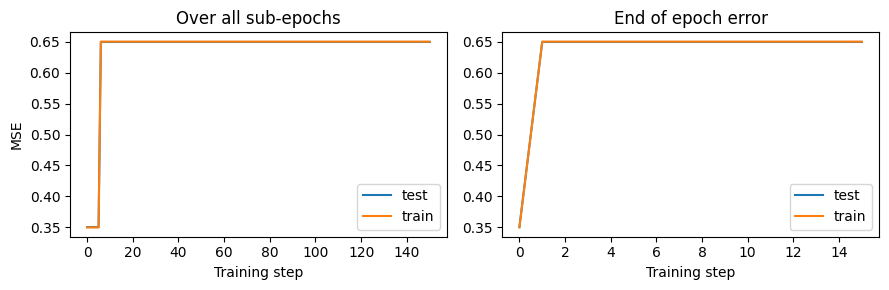

1.1721022975334793e-06
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


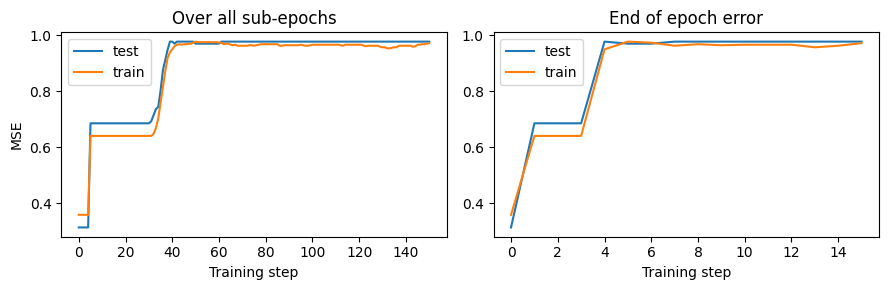

2.592943797404667e-06
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


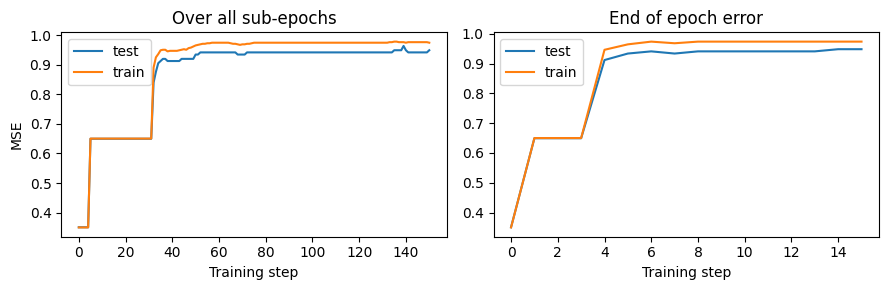

5.736152510448681e-06
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


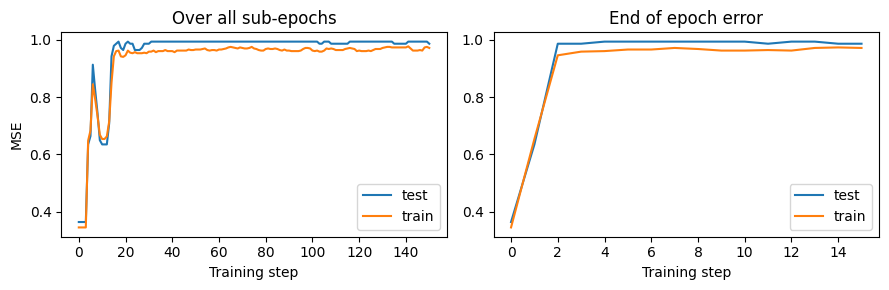

1.2689610031679234e-05
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


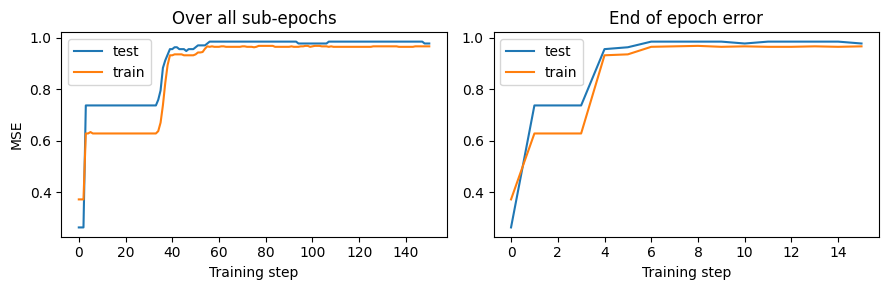

2.8072162039411814e-05
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


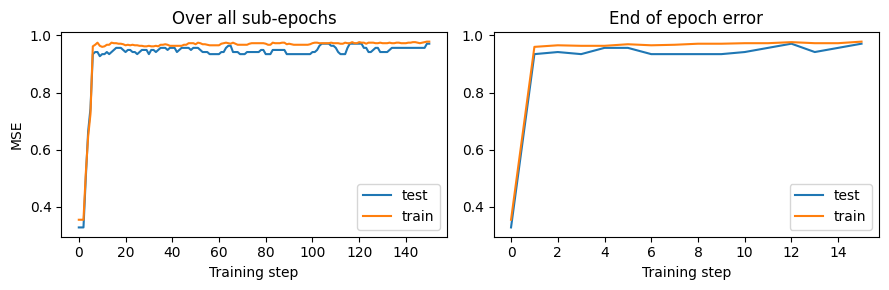

6.210169418915616e-05
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


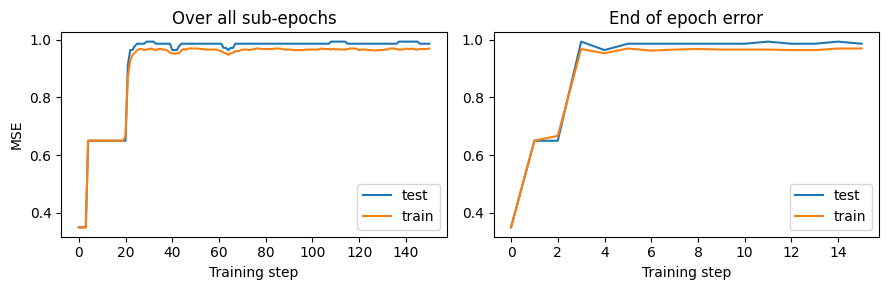

0.00013738237958832637
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


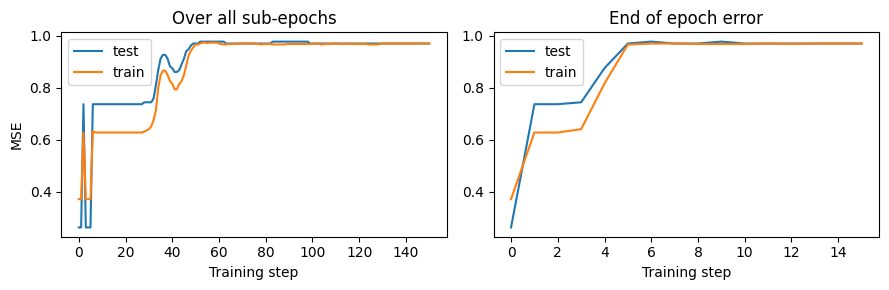

0.0003039195382313201
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


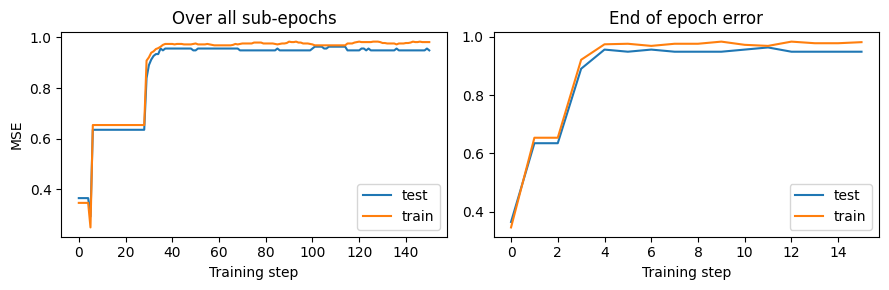

0.0006723357536499335
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


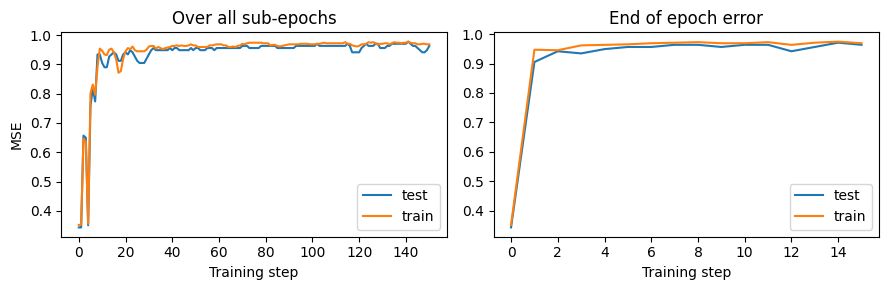

0.0014873521072935117
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


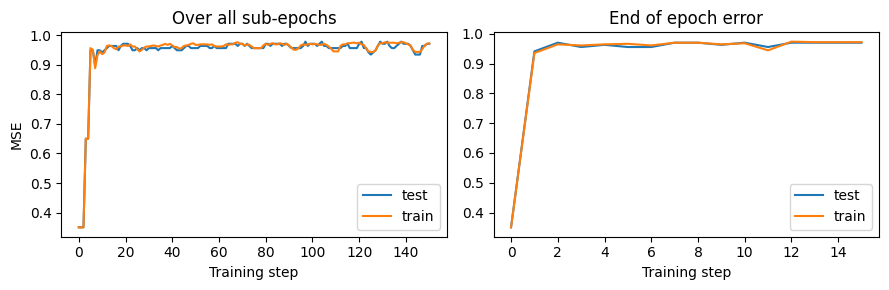

0.003290344562312671
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


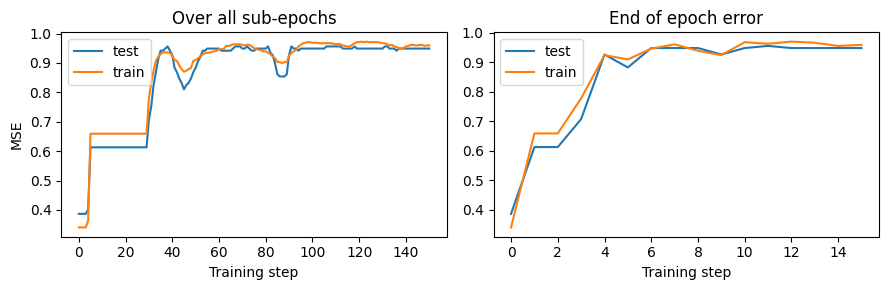

0.0072789538439831615
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


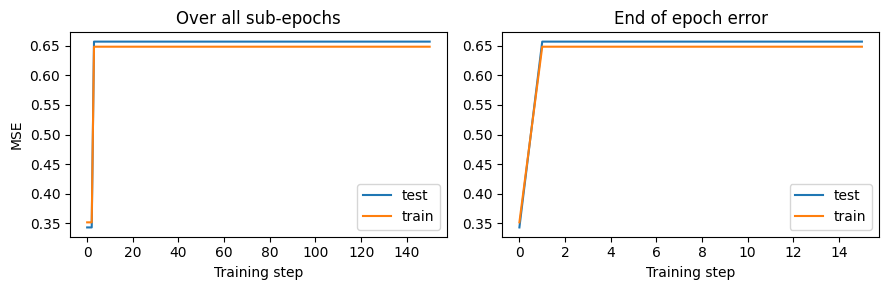

0.016102620275609426
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


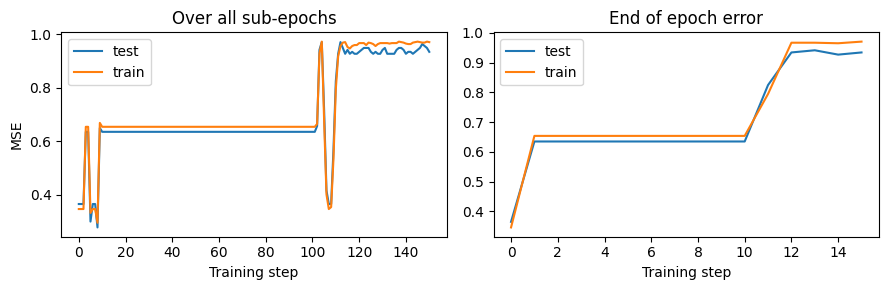

0.03562247890262444
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


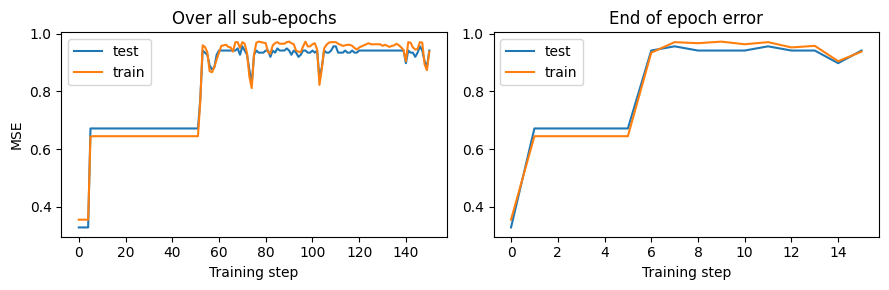

0.0788046281566992
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


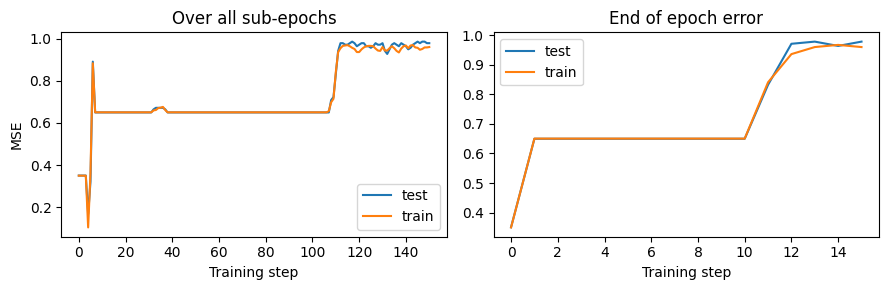

0.1743328822199991
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


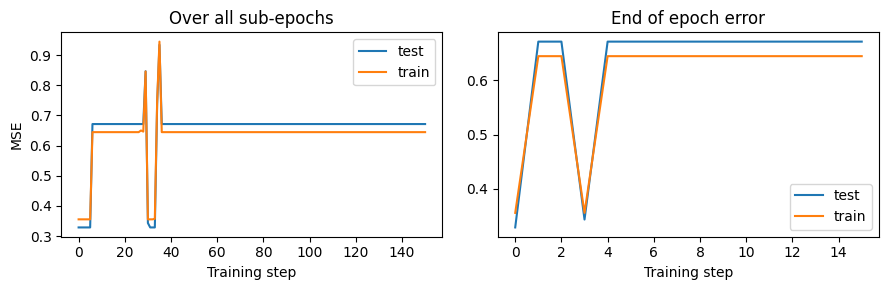

0.38566204211634725
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


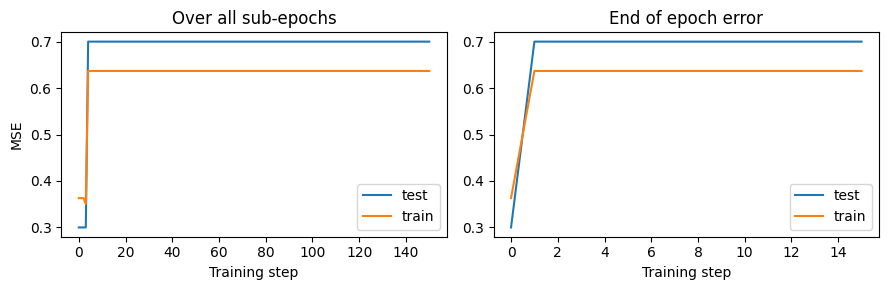

0.8531678524172814
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


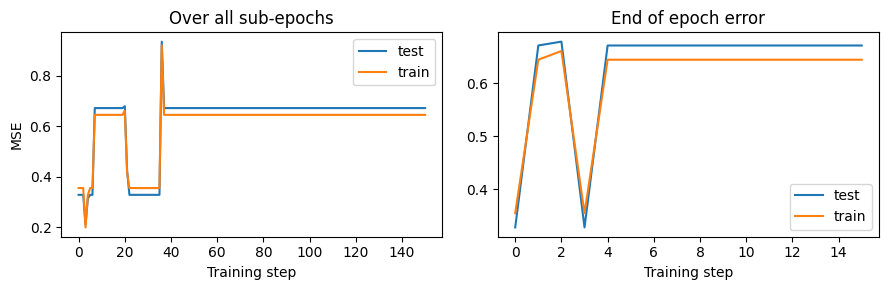

1.8873918221350996
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


KeyboardInterrupt: 

In [11]:
def search_lam():
    lams = np.logspace(-8, 2, num=30)
    test_errs = []
    train_errs = []
    for lam in lams:
        print(lam)
        result = single_run(X, y, lr=0.1, lam=lam, hidden_layer_num=2, node_per_hidden=5, hidden_activation=nn.leaky_relu)
        test_errs.append(result["test_loss_list"][-1])
        train_errs.append(result["train_loss_list"][-1])

    plt.plot(lams, test_errs)
    plt.plot(lams, train_errs)
    plt.xscale("log")
    plt.show()

search_lam()